In [31]:
import xarray as xr
import numpy as np
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from helper import timing_wrapper
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [115]:
training_data_pixel = xr.open_dataset('../../data/training_flat.nc')
training_data_segment = pd.read_csv('../../data/training_segment.csv')[2:]

# undersample the data

X = training_data_pixel[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].to_array().values.T
y = training_data_pixel['y'].values

mask = ~np.isnan(y) & (y != 0) & (y != 3) 

X = X[mask]
y = y[mask]

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

column_names = ['BT_1', 'BT_25', 'BT_35', 'BT_56', 'BT_36', 'sur_rgh', 'neighbor_mean', 'neighbor_std']

resampled_training_data_pixel = pd.DataFrame(X_resampled, columns=column_names)
resampled_training_data_pixel['label'] = y_resampled


/tmp/ipykernel_3768119/206842291.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  training_data_segment = pd.read_csv('../../data/training_segment.csv')[2:]


In [116]:
train, test = train_test_split(resampled_training_data_pixel, test_size=0.3)

In [117]:
predictor = TabularPredictor(label='label').fit(train, time_limit=3600, excluded_model_types=['NN_TORCH', 'GBM', 'CAT', 'XGB', 'FASTAI', 'XT'])

No path specified. Models will be saved in: "AutogluonModels/ag-20240506_155120"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20240506_155120"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Debian 6.1.7

In [118]:
predictor.evaluate(test)


{'accuracy': 0.8603689457493717,
 'balanced_accuracy': 0.860323780971724,
 'mcc': 0.7905750180189673}

In [119]:
distilled = predictor.distill(time_limit=3600)

Distilling with teacher='WeightedEnsemble_L2', teacher_preds=soft, augment_method=spunge ...
SPUNGE: Augmenting training data with 100000 synthetic samples for distillation...


KeyboardInterrupt: 

In [120]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.861186    accuracy       1.921036  186.829414                0.001804           0.160198            2       True          5
1     RandomForestEntr   0.860763    accuracy       0.140195   99.257472                0.140195          99.257472            1       True          4
2     RandomForestGini   0.860287    accuracy       0.147191   79.270809                0.147191          79.270809            1       True          3
3       KNeighborsDist   0.838227    accuracy       1.631846    8.140934                1.631846           8.140934            1       True          2
4       KNeighborsUnif   0.837856    accuracy       1.635687    8.075879                1.635687           8.075879            1       True          1
Number of models trained: 5
Type

In [121]:
ds = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04_v_0.1.nc')
correction_fields = xr.open_dataset('../../data/correction_fields.nc')

In [130]:
@timing_wrapper
def prepare_load_predict(ds, correction_fields=correction_fields):

    timestep = ds.time
    date = timestep.dt.strftime('%Y-%m-%d')
    # select the correction field for the specific date
    cf = correction_fields.BT_2D.sel(time=date)

    bt = ds.BT_2D.values

    # correct the BT_2D
    bt_corrected = bt - cf

    # replace the BT_2D with the corrected values

    ds['BT_2D'].loc[{'band' : [1, 2, 3, 4]}]  = bt_corrected.isel(band=[1, 2, 3, 4])

    X1 = ds.isel(band=0)['BT_2D']
    X2 = ds.isel(band=1)['BT_2D'] - ds.isel(band=3)['BT_2D']
    X3 = ds.isel(band=2)['BT_2D'] - ds.isel(band=3)['BT_2D']
    X4 = ds.isel(band=3)['BT_2D'] - ds.isel(band=4)['BT_2D']
    X5 = ds.isel(band=2)['BT_2D'] - ds.isel(band=4)['BT_2D']
    X6 = ds['sur_rgh']
    X7 = ds['neighbor_mean']
    X8 = ds['neighbor_std']

    skt = X1 * 1.2 + 4.1
    skt = skt.values

    df_X = pd.DataFrame({
        'BT_1' : X1.values.flatten(),
        'BT_25' : X2.values.flatten(),
        'BT_35' : X3.values.flatten(),
        'BT_56' : X4.values.flatten(),
        'BT_36' : X5.values.flatten(),
        'sur_rgh' : X6.values.flatten(),
        'neighbor_mean' : X7.values.flatten(),
        'neighbor_std' : X8.values.flatten()
    })

    pred_proba = predictor.predict_proba(df_X, model= 'RandomForestEntr').values.reshape(635, 507, 3)
    #pred_proba = predictor.predict_proba(df_X).values.reshape(635, 507, 3)

    ds_predicted = xr.Dataset(
        {
            'pred_proba': (('x', 'y', 'cl'), pred_proba),
            'label' : (('x', 'y'), np.argmax(pred_proba, axis=-1) * 2 + 1),
            'skin_t' : (('x', 'y'), skt.reshape(635, 507))
        },
        coords={
            'x': ds.x,
            'y': ds.y,
            'cl': ['1', '3', '4']    
        }
    )

    ds_predicted['label'] = xr.where(ds_predicted['label'] == 5, 4, ds_predicted['label'])

    water_ice_mix = (ds_predicted['pred_proba'].sel(cl='1') > .25 ) & (ds_predicted['pred_proba'].sel(cl='3') > .25)

    ### add a second condition for the water_ice_mix: if the skin temperature is below -2.5°C; this is only applied to open water 

    cold_water = (ds_predicted['label'] == 1) & (ds_predicted['skin_t'] < -3.5)
    water_ice_mix = water_ice_mix | cold_water
    ds_predicted['label'] = ds_predicted['label'].where(~water_ice_mix, 2)

    #ice_snow_mix = (ds_predicted['pred_proba'].sel(cl='3') > .45 ) & (ds_predicted['pred_proba'].sel(cl='5') > .45)
    #ds_predicted['label'] = ds_predicted['label'].where(~ice_snow_mix, 4)

    return ds_predicted

Executed prepare_load_predict in 0.9632773399353027 seconds
100 256


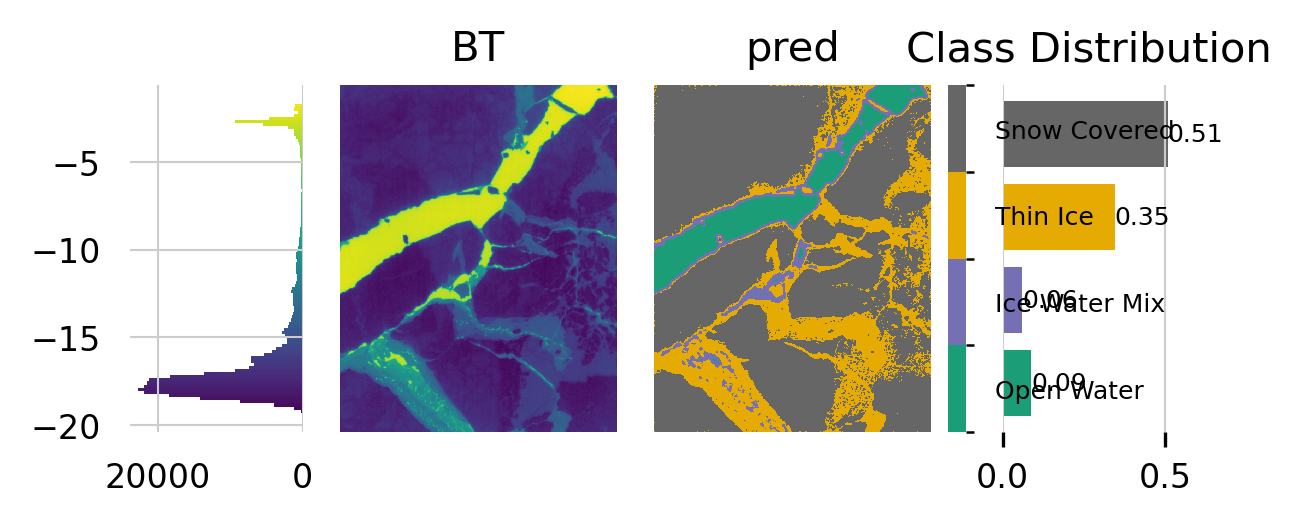

In [228]:
ds_predicted = prepare_load_predict(ds.sel(time='2022-04-04T12:32:32'))

import matplotlib.pyplot as plt
import json
plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))

fig, ax = plt.subplot_mosaic(
    """
    DABC
    """,
    figsize=(4.5, 1.5),
    gridspec_kw={'width_ratios': [.5, 1, 1, .5], 
                 'hspace': 0.05,
                    'wspace': 0.01,
                 
                 }
)

im = ds_predicted['label'].plot.contourf(levels=[0.5, 1.5, 2.5, 3.5, 4.5], cmap='Dark2', ax=ax['B'], add_colorbar=True, cbar_kwargs={'shrink': 1})
cbar = ax['B'].collections[0].colorbar
cbar.set_ticks([1, 2, 3, 4])
cbar.set_ticklabels(['Open Water', 'Ice Water Mix', 'Thin Ice', 'Snow Covered'], fontsize=6)
cbar.set_label('') 
cbar_ax = cbar.ax


im_norm = plt.Normalize(vmin=ds_predicted.skin_t.min(), vmax=ds_predicted.skin_t.max())


ds_predicted.skin_t.plot.imshow(ax=ax['A'], cmap='viridis',add_colorbar=False)
divider = make_axes_locatable(cbar_ax)
colors = im.cmap([0, 1, 2, 3])

tot_count = 507 * 635

bars =ax['C'].barh([1, 2, 3, 4], [np.sum(ds_predicted['label'] == i) / tot_count for i in [1, 2, 3, 4]], color=colors, )
ax['C'].bar_label(bars, fmt='%.2f', fontsize=6)

ax['A'].set_title('BT')
ax['B'].set_title('pred')
ax['C'].set_title('Class Distribution')


cmap = plt.get_cmap('viridis')
colors_viridis = cmap(np.linspace(0, 1, 256))


im_hist = ax['D'].hist(ds_predicted.skin_t.values.flatten(), bins=100, color='gray', alpha=1, orientation='horizontal')
### reverse the x-axis

ax['D'].invert_xaxis()

### change the color of the bars to the colormap of the skin temperature plot

print(len(im_hist[2]), len(colors_viridis))

for i, p in enumerate(im_hist[2]):

    p.set_facecolor(colors_viridis[int((i / 100) * 255)])


for a in ax.values():
    a.grid(False)
    a.set_frame_on(False)

ax['A'].set_xticks([])
ax['A'].set_yticks([])
ax['B'].set_xticks([])
ax['B'].set_yticks([])
ax['A'].set_ylabel('')
ax['B'].set_ylabel('')
ax['A'].set_xlabel('')
ax['B'].set_xlabel('')
ax['A'].set_aspect('equal')
ax['B'].set_aspect('equal')
ax['D'].axes.grid(True)
ax['D'].axes.yaxis.set_tick_params(width=0)
ax['D'].axes.xaxis.set_tick_params(width=0)
ax['C'].axes.grid(True) 
ax['C'].axes.yaxis.set_tick_params(width=0)
ax['C'].set_yticks([])
cbar_ax.set_frame_on(False)
cbar_ax.axes.yaxis.set_tick_params(width=0)
### set the y-distance between colors in the colorbar 


Computing feature importance via permutation shuffling for 8 features using 5000 rows with 5 shuffle sets...
	27.54s	= Expected runtime (5.51s per shuffle set)
	6.67s	= Actual runtime (Completed 5 of 5 shuffle sets)


<Axes: >

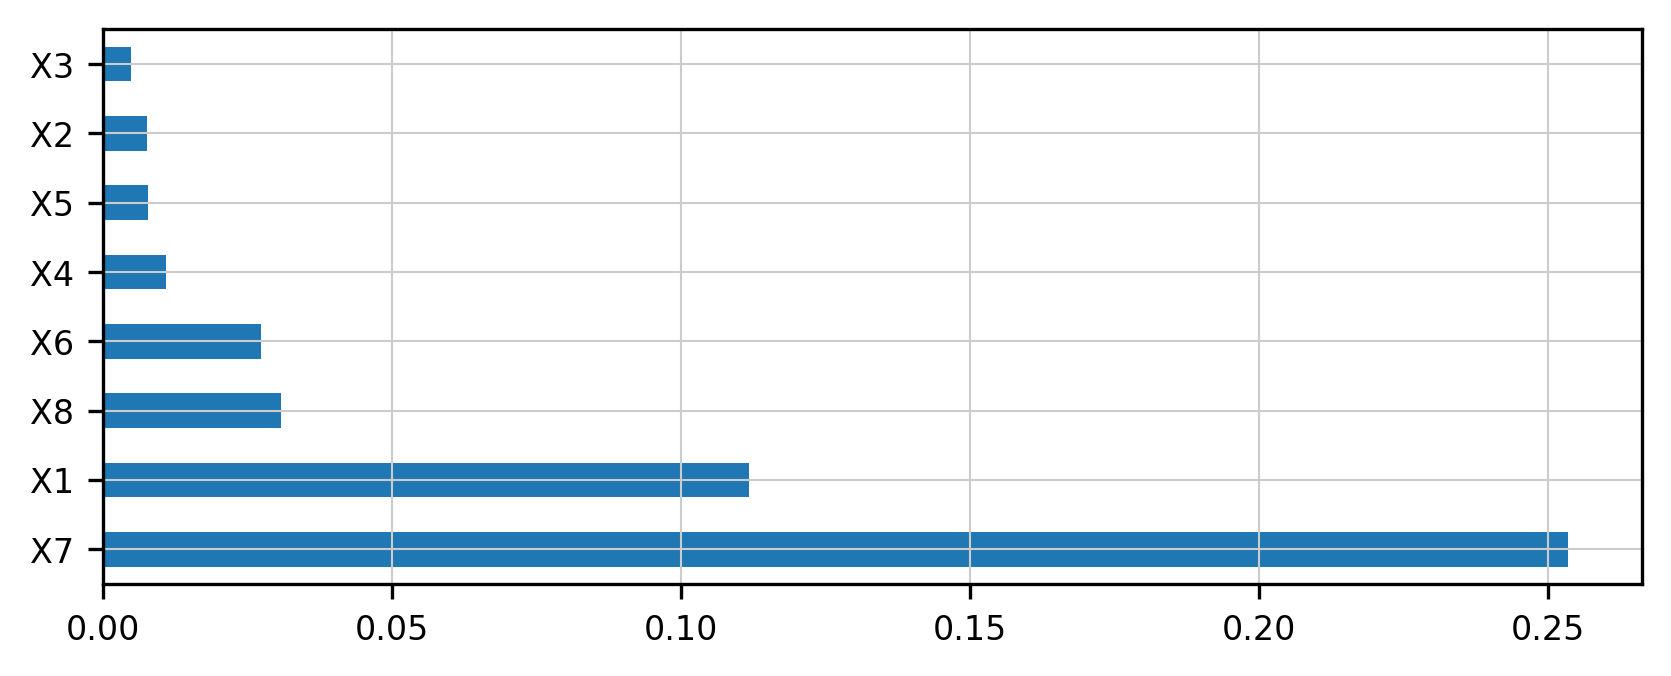

In [113]:
predictor.feature_importance(test, model= 'RandomForestEntr')['importance'].plot.barh()
